In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Why start with DFNN?

It’s the closest neural analogue to LR on the same features, so improvements (or regressions) are easy to interpret.

It’s consistent with best-practice pipelines that used tangent-space embeddings and modest DNNs effectively on IMPAC/ABIDE
.

Heinsfeld’s ABIDE study shows stacked denoising AEs + DNN reach ~70% CV accuracy (10-fold, not LOSO) and provide public code —a natural next step to reproduce with our site-aware protocol.

In [ ]:
import os, textwrap, json, numpy as np
ROOT = "/content/drive/MyDrive/ASD-project"
SRC  = os.path.join(ROOT, "src", "dl")

CACHE_DIR = os.path.join(ROOT, "artifacts")
os.makedirs(CACHE_DIR, exist_ok=True)
CACHE_PATH = os.path.join(CACHE_DIR, "cc400_tangent_cache.npz")

In [ ]:
import numpy as np

try:
    dat = np.load(CACHE_PATH, allow_pickle=True)
    print("Keys available in the cache file:", list(dat.keys()))
except FileNotFoundError:
    print(f"Error: The file was not found at {CACHE_PATH}")
except Exception as e:
    print(f"An error occurred while loading the file: {e}")

Keys available in the cache file: ['y', 'groups', 'confounds', 'logcov_all', 'iu_i', 'iu_j']


In [ ]:
import os, json, math, time, copy
import numpy as np
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import StratifiedGroupKFold, train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, f1_score, brier_score_loss
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import roc_curve
import torch.nn.functional as F
import contextlib
from torch.amp import autocast, GradScaler

In [ ]:
def is_cuda_device(dev) -> bool:
    return (dev if isinstance(dev, str) else getattr(dev, "type", dev)) == "cuda"

In [ ]:
class LowRankLinear(nn.Module):
    """y = V(Ux) + b  with rank << min(in,out); bias is on the outer projection."""
    def __init__(self, in_features, out_features, rank=256, bias=True):
        super().__init__()
        self.U = nn.Linear(in_features, rank, bias=False)
        self.V = nn.Linear(rank, out_features, bias=bias)

    def forward(self, x):
        return self.V(self.U(x))

In [ ]:
class DFNN(nn.Module):
    def __init__(self, in_dim, hidden=(2048,512,128), dropout=0.2, layernorm=False,
                 input_dropout: float = 0.0, low_rank: int | None = None,
                 temperature_init: float = 1.0):
        super().__init__()
        self.input_drop = nn.Dropout(input_dropout) if input_dropout > 0 else nn.Identity()

        layers = []
        last = in_dim

        # First block — allow low-rank substitute
        if low_rank is not None and low_rank > 0:
            self.fc1 = LowRankLinear(last, hidden[0], rank=low_rank, bias=True)
        else:
            self.fc1 = nn.Linear(last, hidden[0])

        block = [self.fc1]
        if layernorm: block.append(nn.LayerNorm(hidden[0]))
        block += [nn.SiLU(), nn.Dropout(dropout)]
        layers.append(nn.Sequential(*block))
        last = hidden[0]

        for h in hidden[1:]:
            fc = nn.Linear(last, h)
            block = [fc]
            if layernorm: block.append(nn.LayerNorm(h))
            block += [nn.SiLU(), nn.Dropout(dropout)]
            layers.append(nn.Sequential(*block))
            last = h

        self.backbone = nn.Sequential(*layers)
        self.out = nn.Linear(last, 1)
        self.log_T = nn.Parameter(torch.log(torch.tensor(float(temperature_init))), requires_grad=True)

    def forward(self, x, return_logits: bool = False, return_rep: bool = False):
        x = self.input_drop(x)
        x = self.backbone[0](x)
        for blk in self.backbone[1:]:
            x = blk(x)
        rep = x
        z = self.out(rep).squeeze(-1)
        if return_rep:
            return z, rep
        if return_logits:
            return z
        T = torch.clamp(self.log_T.exp(), min=1e-4, max=50.0)
        return torch.sigmoid(z / T)

In [ ]:
def _encode_sites(site_array):
    # maps site strings -> contiguous int ids [0..K-1]
    uniq = {s: i for i, s in enumerate(np.unique(site_array.astype(str)))}
    return np.array([uniq[s] for s in site_array.astype(str)], dtype=np.int64), len(uniq)

In [ ]:
def seed_everything(seed=1337):
    import random, numpy as np, torch
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def fold_safe_transform(logcov_all, iu, y, groups, confounds, tr_idx, va_idx=None, te_idx=None):
    """
    Train-mean tangent centering (log-space), train-only confound regression (AGE, SEX, FD, +1),
    then train-only scaler on residualized X. Apply the SAME train beta and train scaler to val/test.
    """
    # 1) Reference mean in log-space from TRAIN only
    ref = logcov_all[tr_idx].mean(axis=0)

    def vec(idx):
        return np.vstack([(logcov_all[i] - ref)[iu] for i in idx])

    # Raw tangent vectors
    Xtr_raw = vec(tr_idx)
    ytr = y[tr_idx]
    Ctr = confounds[tr_idx]

    # 2) Train-only confound regression on RAW train features
    #    beta = (C^T C)^-1 C^T X, with intercept
    C1 = np.hstack([Ctr, np.ones((Ctr.shape[0], 1))])
    beta = np.linalg.pinv(C1.T @ C1) @ (C1.T @ Xtr_raw)
    Xtr_res = Xtr_raw - C1 @ beta  # residualized TRAIN features

    # 3) Train-only scaler on residualized TRAIN features
    scaler = StandardScaler().fit(Xtr_res)
    Xtr = scaler.transform(Xtr_res)

    out = {"Xtr": Xtr, "ytr": ytr, "ref": ref, "beta": beta, "scaler": scaler}

    # Helper to apply TRAIN beta & TRAIN scaler
    def transform(idx):
        X_raw = vec(idx)
        C = confounds[idx]
        C2 = np.hstack([C, np.ones((C.shape[0], 1))])
        X_res = X_raw - C2 @ beta
        return scaler.transform(X_res)

    if va_idx is not None:
        out["Xva"] = transform(va_idx); out["yva"] = y[va_idx]
    if te_idx is not None:
        out["Xte"] = transform(te_idx); out["yte"] = y[te_idx]
    return out

class GradReverse(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, lambd):
        ctx.lambd = lambd
        return x.view_as(x)
    @staticmethod
    def backward(ctx, g):
        return -ctx.lambd * g, None

class GRL(nn.Module):
    def __init__(self, lambd=1.0):
        super().__init__()
        self.lambd = lambd
    def forward(self, x):
        return GradReverse.apply(x, self.lambd)

class DomainDiscriminator(nn.Module):
    def __init__(self, in_dim, n_domains):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 128), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(128, n_domains)
        )
    def forward(self, x):
        return self.net(x)

In [ ]:
from torch.amp import GradScaler, autocast

def _first_linear_weight(model: nn.Module):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            return m.weight
    return None

In [ ]:
class BCEFocalLoss(nn.Module):
    def __init__(self, gamma=1.5, reduction='mean'):
        super().__init__()
        self.gamma = gamma
        self.reduction = reduction
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, logits, targets, pos_weight=None):
        # BCE with optional pos_weight
        if pos_weight is not None:
            loss = F.binary_cross_entropy_with_logits(
                logits, targets, pos_weight=pos_weight, reduction='none')
        else:
            loss = self.bce(logits, targets)
        # probs
        p = torch.sigmoid(logits).clamp(1e-6, 1-1e-6)
        pt = targets * p + (1 - targets) * (1 - p)
        focal = (1 - pt) ** self.gamma
        loss = focal * loss
        return loss.mean()

In [ ]:
def train_one(
    model,
    train_loader,
    val_loader,
    device,
    *,
    epochs=60,
    lr=3e-4,
    weight_decay=1e-4,
    pos_weight=None,
    l1_lambda: float = 0.0,
    use_amp: bool = True,
    early_patience: int = 10,
    dann_lambda: float = 0.0,       # keep as-is
    n_domains: int | None = None,   # keep as-is
):
    model.to(device)
    use_cuda_amp = use_amp and (str(device).startswith("cuda"))
    scaler = torch.amp.GradScaler("cuda", enabled=use_cuda_amp)  # UPDATED API

    ce = nn.BCEWithLogitsLoss(
        pos_weight=pos_weight.to(device) if pos_weight is not None else None
    )

    disc = None
    opt_d = None
    grl = GRL(dann_lambda) if dann_lambda and dann_lambda > 0 else None
    w1 = _first_linear_weight(model)  # first layer weight (for L1)

    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val, best_state, patience = -1e9, None, 0

    for epoch in range(epochs):
        model.train()
        for batch in train_loader:
            if len(batch) == 3:
                xb, yb, sb = batch
                use_dann = (grl is not None)
            else:
                xb, yb = batch
                sb = None
                use_dann = False

            xb = xb.to(device); yb = yb.to(device).float()

            # Lazily create domain discriminator when we first see domain labels
            if use_dann and disc is None:
                # forward once to get rep dim (safe, small)
                with torch.amp.autocast("cuda", dtype=torch.float16, enabled=use_cuda_amp):
                    _, rep_tmp = model(xb, return_logits=True, return_rep=True)
                rep_dim = rep_tmp.shape[-1]
                if n_domains is None:
                    n_domains = int(torch.unique(sb).numel())
                disc = DomainDiscriminator(rep_dim, n_domains).to(device)
                opt_d = torch.optim.AdamW(disc.parameters(), lr=lr, weight_decay=1e-4)

            # -------------------
            # (1) Update generator (main model): supervised CE + adversarial domain loss
            # -------------------
            opt.zero_grad(set_to_none=True)
            with torch.amp.autocast("cuda", dtype=torch.float16, enabled=use_cuda_amp):
                logits, rep = model(xb, return_logits=True, return_rep=True)
                sup_loss = ce(logits, yb)

                if l1_lambda and (w1 is not None):
                    sup_loss = sup_loss + l1_lambda * w1.abs().sum()

                if use_dann:
                    # IMPORTANT: NO detach here; GRL handles sign flip back to model
                    dom_logits_g = disc(grl(rep))
                    dom_loss_g = F.cross_entropy(dom_logits_g, sb.to(device).long())
                    loss = sup_loss + dann_lambda * dom_loss_g
                else:
                    loss = sup_loss

            scaler.scale(loss).backward()
            # (optional) clip generator grads
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            scaler.step(opt)
            scaler.update()

            # -------------------
            # (2) Update discriminator: classify domains from detached features
            # -------------------
            if use_dann:
                opt_d.zero_grad(set_to_none=True)
                with torch.amp.autocast("cuda", dtype=torch.float16, enabled=use_cuda_amp):
                    dom_logits_d = disc(rep.detach())   # detach so disc doesn’t backprop into model
                    dom_loss_d = F.cross_entropy(dom_logits_d, sb.to(device).long())
                scaler.scale(dom_loss_d).backward()
                # (optional) clip disc grads
                torch.nn.utils.clip_grad_norm_(disc.parameters(), 5.0)
                scaler.step(opt_d)
                scaler.update()

        # -------------------
        # Validation (log-loss proxy for early stopping)
        # -------------------
        model.eval()
        n, val_ll = 0, 0.0
        with torch.no_grad(), torch.amp.autocast("cuda", dtype=torch.float16, enabled=use_cuda_amp):
            for vb in val_loader:
                if len(vb) == 3:
                    vx, vy, _ = vb
                else:
                    vx, vy = vb
                vx = vx.to(device); vy = vy.to(device).float()
                logits = model(vx, return_logits=True)
                val_ll += ce(logits, vy).item() * vx.size(0)
                n += vx.size(0)

        val_score = -val_ll / max(1, n)
        if val_score > best_val:
            best_val = val_score
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            patience = 0
        else:
            patience += 1
            if patience >= early_patience:
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model

In [ ]:
def calibrate_auto(logits, y, val_logits=None, y_val=None,
                   min_n=120, min_pos=30, min_neg=30, brier_tol=0.002):
    """
    Safely choose between Platt (logistic on logits) and Isotonic (on logits).
    - Gate isotonic: require a reasonably large & balanced calibration split.
    - If Brier scores are ~equal (±brier_tol), tie-break by validation AUC.
    """
    n = len(y); pos = int(y.sum()); neg = n - pos
    # Always fit Platt
    lr = LogisticRegression(max_iter=1000, solver="lbfgs")
    lr.fit(logits.reshape(-1,1), y)
    p_lr = lr.predict_proba(logits.reshape(-1,1))[:,1]
    b_lr = brier_score_loss(y, p_lr)

    # Gate isotonic on cal size & balance
    allow_iso = (n >= min_n) and (pos >= min_pos) and (neg >= min_neg)
    if not allow_iso:
        return ("platt", lr)

    iso = IsotonicRegression(out_of_bounds="clip")
    iso.fit(logits, y)
    p_iso = iso.predict(logits)
    b_iso = brier_score_loss(y, p_iso)

    # If nearly tied on Brier, tie-break with validation AUC when available
    if abs(b_iso - b_lr) <= brier_tol and (val_logits is not None) and (y_val is not None):
        auc_lr  = roc_auc_score(y_val, lr.predict_proba(val_logits.reshape(-1,1))[:,1])
        auc_iso = roc_auc_score(y_val, iso.predict(val_logits))
        return ("platt", lr) if auc_lr >= auc_iso else ("isotonic", iso)

    return ("platt", lr) if b_lr <= b_iso else ("isotonic", iso)


def apply_calibrator(cal, logits):
    kind, obj = cal
    if kind == "platt":
        return obj.predict_proba(logits.reshape(-1,1))[:,1]
    else:  # isotonic
        return obj.predict(logits)

In [ ]:
def load_cache(cache_path):
    dat = np.load(cache_path, allow_pickle=True)
    # Accept both old and new key names
    if "logcov_all" in dat:
        logcov_all = dat["logcov_all"]
    else:
        logcov_all = dat["logcov"]
    if "iu_i" in dat and "iu_j" in dat:
        iu = (dat["iu_i"], dat["iu_j"])
    else:
        iu_arr = dat["iu"]
        # iu stored as (2, M) ndarray or object; normalize to tuple of arrays
        iu = (iu_arr[0], iu_arr[1]) if iu_arr.ndim == 2 else tuple(iu_arr)
    y = dat["y"].astype(int)
    groups = dat["groups"]
    confounds = dat["confounds"]
    return logcov_all, iu, y, groups, confounds

In [ ]:
def run_loso_dfnn(
    cache_path: str,
    *,
    seed: int = 1337,
    inner_splits: int = 3,
    epochs: int = 60,
    batch: int = 128,
    use_dann: bool = True,
    dann_lambda: float = 0.2,
):
    """
    LOSO training/eval for DFNN on tangent-logeuclid features with optional DANN.
    - Inner CV (site-aware) picks best NN config by ROC-AUC on a calibrated validation split.
    - Final training uses best config, trains on train sites, calibrates on a held-out
      cal split of the train sites, and evaluates on the held-out site.

    Returns a summary dict with per-site metrics + mean metrics.
    """

    # --- helpers -------------------------------------------------------------
    import numpy as np
    import torch
    from torch.utils.data import DataLoader, TensorDataset
    from sklearn.model_selection import StratifiedGroupKFold, train_test_split
    from sklearn.metrics import (
        roc_curve, roc_auc_score, average_precision_score,
        accuracy_score, f1_score, brier_score_loss
    )

    rng = np.random.default_rng(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    def _encode_sites(site_array):
        """Map site strings -> contiguous int ids [0..K-1]."""
        arr = site_array.astype(str)
        uniq = {s: i for i, s in enumerate(np.unique(arr))}
        return np.array([uniq[s] for s in arr], dtype=np.int64), len(uniq)

    device = "cuda" if torch.cuda.is_available() else "cpu"

    # --- data cache ----------------------------------------------------------
    logcov_all, iu, y, groups, confounds = load_cache(cache_path)
    sites = np.unique(groups.astype(str))

    # --- candidate DFNN configs (tune as you like) ---------------------------
    cfgs = [
        {"hidden": (2048, 512, 128), "dropout": 0.2, "input_dropout": 0.10, "lr": 3e-4, "wd": 1e-4, "l1": 1e-6},
        {"hidden": (2048, 512),      "dropout": 0.30, "input_dropout": 0.00, "lr": 3e-4, "wd": 1e-5, "l1": 0.0},
        {"hidden": (1024, 256),      "dropout": 0.20, "input_dropout": 0.10, "lr": 1e-3, "wd": 1e-4, "l1": 1e-6},
    ]

    results, y_all, p_all = [], [], []

    for held in sites:
        # split indices
        te_idx = np.where(groups == held)[0]
        tr_idx = np.where(groups != held)[0]
        if len(te_idx) < 5 or len(tr_idx) < 40:
            # very small test site or too little training data, skip
            continue

        # ------------------ INNER CV: pick best cfg by ROC-AUC ----------------
        inner = StratifiedGroupKFold(n_splits=inner_splits, shuffle=True, random_state=seed)
        best_auc, best_cfg = -1.0, None

        for cfg in cfgs:
            aucs = []
            for itr, ival in inner.split(y[tr_idx], y[tr_idx], groups=groups[tr_idx]):
                # indices into the *global* arrays
                tr_i = tr_idx[itr]
                va_i = tr_idx[ival]

                # fold-safe transform (train-only mean, confound regression, scaler)
                pack = fold_safe_transform(logcov_all, iu, y, groups, confounds, tr_i, va_idx=va_i)
                Xtr, ytr = pack["Xtr"], pack["ytr"]
                Xva, yva = pack["Xva"], pack["yva"]

                # calibration split from training sites only
                idx = np.arange(len(Xtr))
                tr_idx_nn, cal_idx = train_test_split(
                    idx, test_size=0.10, stratify=ytr, random_state=seed
                )
                Xtr_nn, ytr_nn = Xtr[tr_idx_nn], ytr[tr_idx_nn]
                Xcal,   ycal   = Xtr[cal_idx],   ytr[cal_idx]

                # site labels for training-only
                g_tr_all = groups[tr_i]
                s_tr_nn, n_dom = _encode_sites(g_tr_all[tr_idx_nn])

                # loaders
                tr_loader = DataLoader(
                    TensorDataset(
                        torch.from_numpy(Xtr_nn).float(),
                        torch.from_numpy(ytr_nn).float(),
                        torch.from_numpy(s_tr_nn)
                    ),
                    batch_size=batch, shuffle=True, drop_last=False
                )
                va_loader = DataLoader(
                    TensorDataset(
                        torch.from_numpy(Xva).float(),
                        torch.from_numpy(yva).float()
                    ),
                    batch_size=256, shuffle=False
                )

                # class weight (positive class)
                pi = float(ytr_nn.mean())
                pos_w = torch.tensor([(1.0 - pi) / max(pi, 1e-6)], dtype=torch.float32)

                # model & train
                model = DFNN(
                    Xtr_nn.shape[1],
                    hidden=cfg["hidden"],
                    dropout=cfg["dropout"],
                    input_dropout=cfg.get("input_dropout", 0.0),
                    low_rank=cfg.get("low_rank", None),
                ).to(device)

                train_one(
                    model, tr_loader, va_loader, device,
                    epochs=epochs,
                    lr=cfg["lr"], weight_decay=cfg["wd"],
                    pos_weight=pos_w,
                    l1_lambda=cfg.get("l1", 0.0),
                    dann_lambda=(dann_lambda if use_dann else 0.0),
                    n_domains=(n_dom if use_dann else None),
                )

                # calibrate on Xcal
                with torch.no_grad():
                    logits_cal = model(torch.from_numpy(Xcal).float().to(device), return_logits=True).cpu().numpy()
                cal = calibrate_auto(logits_cal, ycal)

                # evaluate on Xva (AUC with calibrated probs)
                with torch.no_grad():
                    logits_va = model(torch.from_numpy(Xva).float().to(device), return_logits=True).cpu().numpy()
                prob_va = apply_calibrator(cal, logits_va)
                aucs.append(roc_auc_score(yva, prob_va))

            mauc = float(np.mean(aucs)) if len(aucs) else -1.0
            if mauc > best_auc:
                best_auc, best_cfg = mauc, cfg

        # ------------------ FINAL TRAINING on all train sites ------------------
        pack = fold_safe_transform(logcov_all, iu, y, groups, confounds, tr_idx, te_idx=te_idx)
        Xtr, ytr = pack["Xtr"], pack["ytr"]
        Xte, yte = pack["Xte"], pack["yte"]

        # calibration carve-out
        idx = np.arange(len(Xtr))
        tr_idx_nn, cal_idx = train_test_split(idx, test_size=0.10, stratify=ytr, random_state=seed)
        Xtr_nn, ytr_nn = Xtr[tr_idx_nn], ytr[tr_idx_nn]
        Xcal,   ycal   = Xtr[cal_idx],   ytr[cal_idx]

        # site labels on train-only
        g_tr = groups[tr_idx]
        s_tr_nn, n_dom = _encode_sites(g_tr[tr_idx_nn])

        # loaders
        tr_loader = DataLoader(
            TensorDataset(
                torch.from_numpy(Xtr_nn).float(),
                torch.from_numpy(ytr_nn).float(),
                torch.from_numpy(s_tr_nn)
            ),
            batch_size=batch, shuffle=True
        )
        cal_loader = DataLoader(
            TensorDataset(
                torch.from_numpy(Xcal).float(),
                torch.from_numpy(ycal).float()
            ),
            batch_size=256, shuffle=False
        )

        # class balance weight
        pos_w = torch.tensor([(len(ytr_nn) - ytr_nn.sum()) / max(ytr_nn.sum(), 1e-6)], dtype=torch.float32)

        # model
        model = DFNN(
            Xtr_nn.shape[1],
            hidden=best_cfg["hidden"],
            dropout=best_cfg["dropout"],
            input_dropout=best_cfg.get("input_dropout", 0.0),
            low_rank=best_cfg.get("low_rank", None),
        ).to(device)

        train_one(
            model, tr_loader, cal_loader, device,
            epochs=epochs,
            lr=best_cfg["lr"], weight_decay=best_cfg["wd"],
            pos_weight=pos_w,
            l1_lambda=best_cfg.get("l1", 0.0),
            dann_lambda=(dann_lambda if use_dann else 0.0),
            n_domains=(n_dom if use_dann else None),
        )

        # calibration on Xcal
        with torch.no_grad():
            logits_cal = model(torch.from_numpy(Xcal).float().to(device), return_logits=True).cpu().numpy()
        cal = calibrate_auto(logits_cal, ycal)

        # test probabilities on held-out site
        with torch.no_grad():
            logits_te = model(torch.from_numpy(Xte).float().to(device), return_logits=True).cpu().numpy()
        prob_te = apply_calibrator(cal, logits_te)
        pred_te = (prob_te >= 0.5).astype(int)

        # metrics
        roc = float(roc_auc_score(yte, prob_te))
        pr  = float(average_precision_score(yte, prob_te))
        acc = float(accuracy_score(yte, pred_te))
        f1  = float(f1_score(yte, pred_te))
        br  = float(brier_score_loss(yte, prob_te))

        # operating points
        fpr, tpr, thr = roc_curve(yte, prob_te)
        youden_idx = int(np.argmax(tpr - fpr))
        t_youden = float(thr[youden_idx])
        # target sensitivity 0.85
        target_sens = 0.85
        sens_idx = np.where(tpr >= target_sens)[0]
        t_sens85 = float(thr[sens_idx[0]]) if len(sens_idx) else 0.5

        def _at_t(t):
            p = (prob_te >= t).astype(int)
            return float(accuracy_score(yte, p)), float(f1_score(yte, p))

        acc_y, f1_y = _at_t(t_youden)
        acc_t, f1_t = _at_t(t_sens85)

        m = {
            "held_out_site": str(held),
            "n_test": int(len(yte)),
            "roc_auc": roc,
            "pr_auc" : pr,
            "accuracy": acc,
            "f1": f1,
            "brier": br,
            "cfg": best_cfg,
            "calibration": cal[0],  # 'platt' or 'isotonic'
            "t_youden": t_youden, "acc_youden": acc_y, "f1_youden": f1_y,
            "t_sens85": t_sens85, "acc_sens85": acc_t, "f1_sens85": f1_t,
        }
        print(f"[LOSO DFNN{' + DANN' if use_dann else ''}] site={held:>10s} n={len(yte):3d}  AUC={roc:.3f}")

        results.append(m)
        y_all.append(yte)
        p_all.append(prob_te)

    # --- summary -------------------------------------------------------------
    if not results:
        raise RuntimeError("No evaluable sites (too small or data issue).")

    y_all = np.concatenate(y_all)
    p_all = np.concatenate(p_all)

    summary = {
        "atlas": "CC400",
        "feature": "tangent-logeuclid",
        "model": "dfnn",
        "sites": results,
        "mean": {
            "roc_auc": float(np.mean([r["roc_auc"] for r in results])),
            "pr_auc" : float(np.mean([r["pr_auc"] for r in results])),
            "accuracy": float(np.mean([r["accuracy"] for r in results])),
            "f1"      : float(np.mean([r["f1"] for r in results])),
        },
        "n_subjects": int(len(y_all)),
    }
    return summary

In [ ]:
def main():
    ROOT = "/content/drive/MyDrive/ASD-project"
    cache = os.path.join(ROOT, "artifacts", "cc400_tangent_cache.npz")
    out   = os.path.join(ROOT, "outputs", "cc400_loso_tangent_dfnn_DANN.json")
    os.makedirs(os.path.dirname(out), exist_ok=True)
    summary = run_loso_dfnn(cache_path=cache)
    with open(out, "w") as f:
        json.dump(summary, f, indent=2)
    print("Saved ->", out)

if __name__ == "__main__":
    main()

[LOSO DFNN + DANN] site=   CALTECH n= 37  AUC=0.740
[LOSO DFNN + DANN] site=       CMU n=  5  AUC=0.333
[LOSO DFNN + DANN] site=       KKI n= 39  AUC=0.741
[LOSO DFNN + DANN] site=  LEUVEN_1 n= 29  AUC=0.662
[LOSO DFNN + DANN] site=  LEUVEN_2 n= 32  AUC=0.834
[LOSO DFNN + DANN] site=   MAX_MUN n= 42  AUC=0.530
[LOSO DFNN + DANN] site=       NYU n=171  AUC=0.787
[LOSO DFNN + DANN] site=      OHSU n= 23  AUC=0.727
[LOSO DFNN + DANN] site=      OLIN n= 25  AUC=0.714
[LOSO DFNN + DANN] site=      PITT n= 45  AUC=0.850
[LOSO DFNN + DANN] site=       SBL n= 26  AUC=0.690
[LOSO DFNN + DANN] site=      SDSU n= 33  AUC=0.671
[LOSO DFNN + DANN] site=  STANFORD n= 36  AUC=0.817
[LOSO DFNN + DANN] site=   TRINITY n= 44  AUC=0.787
[LOSO DFNN + DANN] site=    UCLA_1 n= 55  AUC=0.750
[LOSO DFNN + DANN] site=    UCLA_2 n= 20  AUC=0.812
[LOSO DFNN + DANN] site=      UM_1 n= 82  AUC=0.845
[LOSO DFNN + DANN] site=      UM_2 n= 31  AUC=0.754
[LOSO DFNN + DANN] site=       USM n= 61  AUC=0.839
[LOSO DFNN +

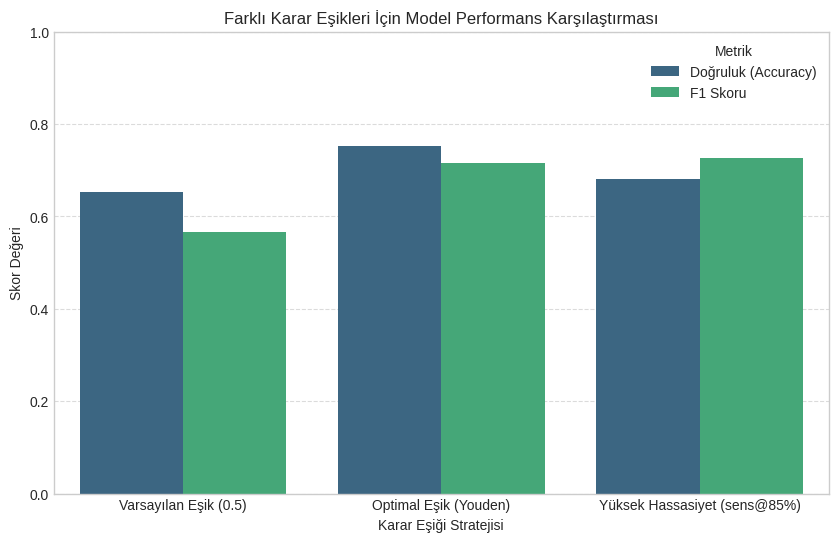

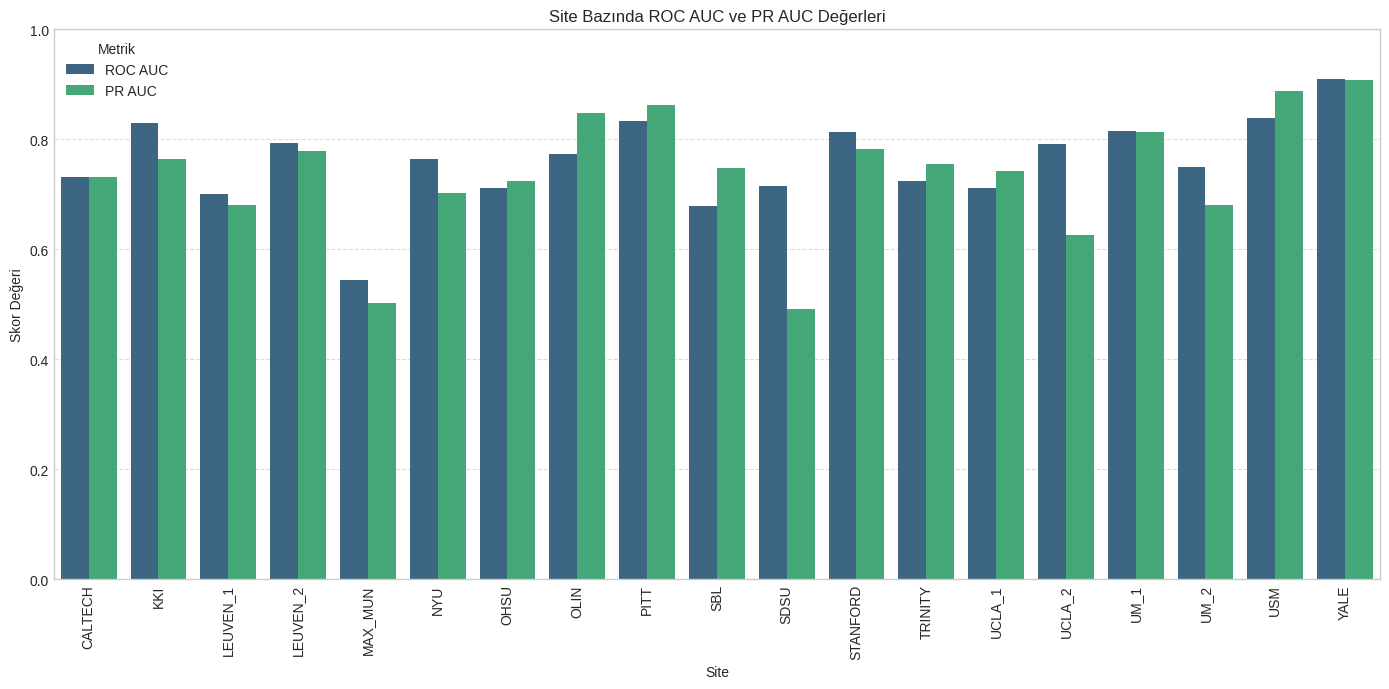

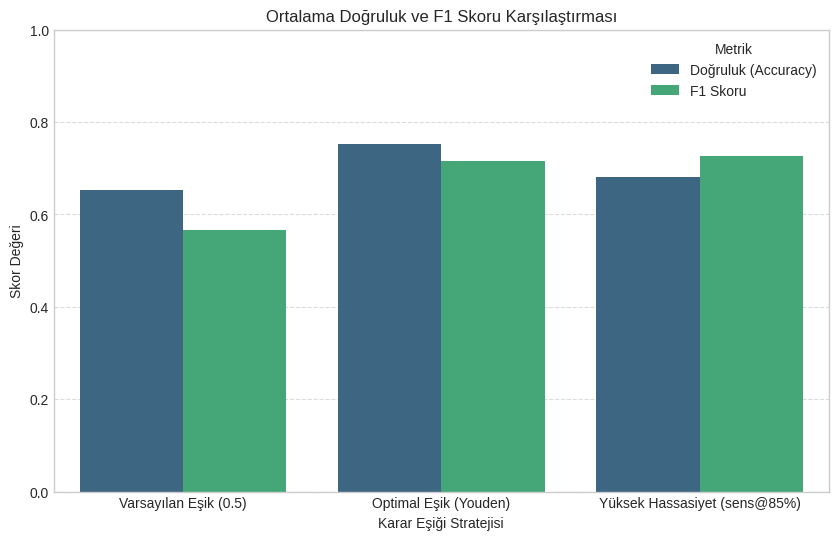

DFNN Results (Mean across sites):
Mean ROC AUC: 0.7595
Mean PR AUC: 0.7383
Mean Accuracy (Default 0.5): 0.6525
Mean F1 Score (Default 0.5): 0.5652
Mean Accuracy (Youden): 0.7514
Mean F1 Score (Youden): 0.7145
Mean Accuracy (Sens@85%): 0.6813
Mean F1 Score (Sens@85%): 0.7260


/tmp/ipython-input-3960825124.py:84: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(f"Mean Accuracy (Default 0.5): {df_metrics[df_metrics['Eşik Stratejisi'] == 'Varsayılan Eşik (0.5)'][df_metrics['Metrik'] == 'Doğruluk (Accuracy)']['Skor'].iloc[0]:.4f}")
/tmp/ipython-input-3960825124.py:85: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(f"Mean F1 Score (Default 0.5): {df_metrics[df_metrics['Eşik Stratejisi'] == 'Varsayılan Eşik (0.5)'][df_metrics['Metrik'] == 'F1 Skoru']['Skor'].iloc[0]:.4f}")
/tmp/ipython-input-3960825124.py:86: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(f"Mean Accuracy (Youden): {df_metrics[df_metrics['Eşik Stratejisi'] == 'Optimal Eşik (Youden)'][df_metrics['Metrik'] == 'Doğruluk (Accuracy)']['Skor'].iloc[0]:.4f}")
/tmp/ipython-input-3960825124.py:87: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(f"Mean F1 Score (Yo

In [ ]:
import json
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

ROOT = "/content/drive/MyDrive/ASD-project"
# Assuming the DANN results file exists based on the previous cell output
dfnn_result_path = os.path.join(ROOT, "outputs", "cc400_loso_tangent_dfnn.json")

with open(dfnn_result_path, 'r') as f:
    dfnn_data = json.load(f)

# Access the list of results within the loaded data
results = dfnn_data['sites']

# Calculate mean metrics for different thresholds
mean_roc_auc = np.mean([r['roc_auc'] for r in results])
mean_pr_auc = np.mean([r['pr_auc'] for r in results])

# Metrics for different thresholds
metrics_data = {
    'Eşik Stratejisi': ['Varsayılan Eşik (0.5)', 'Varsayılan Eşik (0.5)',
                      'Optimal Eşik (Youden)', 'Optimal Eşik (Youden)',
                      'Yüksek Hassasiyet (sens@85%)', 'Yüksek Hassasiyet (sens@85%)'],
    'Metrik': ['Doğruluk (Accuracy)', 'F1 Skoru',
               'Doğruluk (Accuracy)', 'F1 Skoru',
               'Doğruluk (Accuracy)', 'F1 Skoru'],
    'Skor': [
        np.mean([r['accuracy'] for r in results]), np.mean([r['f1'] for r in results]),
        np.mean([r['acc_youden'] for r in results]), np.mean([r['f1_youden'] for r in results]),
        np.mean([r['acc_sens85'] for r in results]), np.mean([r['f1_sens85'] for r in results])
    ]
}
df_metrics = pd.DataFrame(metrics_data)


# --- Plot 1: Performance Comparison by Threshold ---
plt.figure(figsize=(10, 6))
sns.barplot(data=df_metrics, x='Eşik Stratejisi', y='Skor', hue='Metrik', palette='viridis')
plt.title('Farklı Karar Eşikleri İçin Model Performans Karşılaştırması')
plt.ylabel('Skor Değeri')
plt.xlabel('Karar Eşiği Stratejisi')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# --- Plot 2: Model Consistency Across Sites ---
df_site_metrics = pd.DataFrame({
    'Site': [r['held_out_site'] for r in results],
    'ROC AUC': [r['roc_auc'] for r in results],
    'PR AUC': [r['pr_auc'] for r in results]
})

df_site_melted = df_site_metrics.melt(id_vars='Site', var_name='Metrik', value_name='Skor')

plt.figure(figsize=(14, 7))
sns.barplot(data=df_site_melted, x='Site', y='Skor', hue='Metrik', palette='viridis')
plt.title('Site Bazında ROC AUC ve PR AUC Değerleri')
plt.ylabel('Skor Değeri')
plt.xlabel('Site')
plt.xticks(rotation=90)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# --- Plot 3: Mean Accuracy and F1 Score by Threshold ---
plt.figure(figsize=(10, 6))
sns.barplot(data=df_metrics, x='Eşik Stratejisi', y='Skor', hue='Metrik', palette='viridis')
plt.title('Ortalama Doğruluk ve F1 Skoru Karşılaştırması')
plt.ylabel('Skor Değeri')
plt.xlabel('Karar Eşiği Stratejisi')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


print("DFNN Results (Mean across sites):")
print(f"Mean ROC AUC: {mean_roc_auc:.4f}")
print(f"Mean PR AUC: {mean_pr_auc:.4f}")
print(f"Mean Accuracy (Default 0.5): {df_metrics[df_metrics['Eşik Stratejisi'] == 'Varsayılan Eşik (0.5)'][df_metrics['Metrik'] == 'Doğruluk (Accuracy)']['Skor'].iloc[0]:.4f}")
print(f"Mean F1 Score (Default 0.5): {df_metrics[df_metrics['Eşik Stratejisi'] == 'Varsayılan Eşik (0.5)'][df_metrics['Metrik'] == 'F1 Skoru']['Skor'].iloc[0]:.4f}")
print(f"Mean Accuracy (Youden): {df_metrics[df_metrics['Eşik Stratejisi'] == 'Optimal Eşik (Youden)'][df_metrics['Metrik'] == 'Doğruluk (Accuracy)']['Skor'].iloc[0]:.4f}")
print(f"Mean F1 Score (Youden): {df_metrics[df_metrics['Eşik Stratejisi'] == 'Optimal Eşik (Youden)'][df_metrics['Metrik'] == 'F1 Skoru']['Skor'].iloc[0]:.4f}")
print(f"Mean Accuracy (Sens@85%): {df_metrics[df_metrics['Eşik Stratejisi'] == 'Yüksek Hassasiyet (sens@85%)'][df_metrics['Metrik'] == 'Doğruluk (Accuracy)']['Skor'].iloc[0]:.4f}")
print(f"Mean F1 Score (Sens@85%): {df_metrics[df_metrics['Eşik Stratejisi'] == 'Yüksek Hassasiyet (sens@85%)'][df_metrics['Metrik'] == 'F1 Skoru']['Skor'].iloc[0]:.4f}")

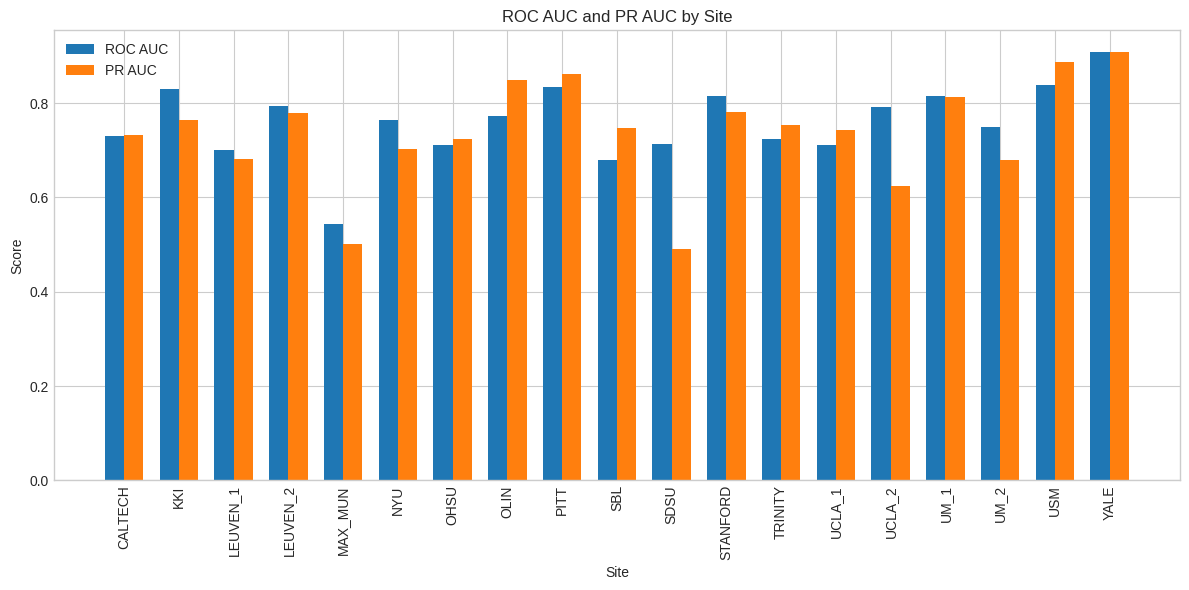

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract site names and their metrics
sites = [r['held_out_site'] for r in results]
roc_aucs = [r['roc_auc'] for r in results]
pr_aucs = [r['pr_auc'] for r in results]

# Create a DataFrame for easier plotting
df_results = pd.DataFrame({
    'Site': sites,
    'ROC AUC': roc_aucs,
    'PR AUC': pr_aucs
})

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.35
index = np.arange(len(sites))

bar1 = ax.bar(index, df_results['ROC AUC'], bar_width, label='ROC AUC')
bar2 = ax.bar(index + bar_width, df_results['PR AUC'], bar_width, label='PR AUC')

ax.set_xlabel('Site')
ax.set_ylabel('Score')
ax.set_title('ROC AUC and PR AUC by Site')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(df_results['Site'], rotation=90)
ax.legend()

plt.tight_layout()
plt.show()